#Imports

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statistics as stat

from datetime import date

from sklearn.feature_selection import SelectKBest, chi2
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import RandomOverSampler

import warnings
warnings.filterwarnings('ignore')

orig_train = pd.read_parquet('train.parquet')

#Primary information

In [ ]:
orig_train.head()

id                                              dates  \
0  19114  [2016-01-01, 2016-02-01, 2016-03-01, 2016-04-0...   
1  22769  [2016-05-01, 2016-06-01, 2016-07-01, 2016-08-0...   
2  76935  [2017-03-01, 2017-04-01, 2017-05-01, 2017-06-0...   
3  66297  [2016-01-01, 2016-02-01, 2016-03-01, 2016-04-0...   
4   2191  [2016-01-01, 2016-02-01, 2016-03-01, 2016-04-0...   

                                              values  label  
0  [-1.86, 0.79, 1.4, 0.15, 0.0, -1.24, -1.46, 3....    0.0  
1  [-1.04, -3.48, 0.05, -0.13, -0.01, 0.03, 0.27,...    1.0  
2  [0.28, 0.63, 0.06, 0.96, -1.4, -0.3, 1.62, 1.1...    0.0  
3  [-0.33, 0.58, 1.1, -0.56, -0.95, -0.61, -0.7, ...    0.0  
4  [1.31, 0.5, -0.54, 0.95, 0.65, 0.83, -1.55, -0...    0.0

In [ ]:
#describle statistic
orig_train.describe()

id         label
count  80000.000000  80000.000000
mean   50107.893162      0.277250
std    28857.649778      0.447644
min        0.000000      0.000000
25%    25122.500000      0.000000
50%    50146.500000      0.000000
75%    75064.250000      1.000000
max    99999.000000      1.000000

In [ ]:
cols, rows = orig_train.shape
print('Number of columns: ', cols, '\nNumber of rows: ', rows)

Number of columns:  80000 
Number of rows:  4


In [ ]:
orig_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80000 entries, 0 to 79999
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   id      80000 non-null  int64  
 1   dates   80000 non-null  object 
 2   values  80000 non-null  object 
 3   label   80000 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 2.4+ MB


In [ ]:
#check is there null values and how many of them
describe_df = pd.DataFrame()
describe_df['nulls'] = orig_train.isnull().sum()
describe_df

#checking every number in every array
nulls_vals = [pd.isna(x).tolist().count(True) for x in orig_train['values']].count(1)
print('number of nulls in arrays of values:', nulls_vals)
nulls_dates = [pd.isna(x).tolist().count(True) for x in orig_train['dates']].count(1)
print('number of nulls in arrays of dates:', nulls_dates)

number of nulls in arrays of values: 0
number of nulls in arrays of dates: 0


In [ ]:
#somewhere could be full nan or partly nan values in array:
ind_values = []
for x in range(len(orig_train['values'])):
  for part in orig_train['values'][x]:
    if str(part) == 'nan':
      ind_values.append(x)
      break
ind_dates = []
for x in range(len(orig_train['dates'])):
  for part in orig_train['dates'][x]:
    if str(part) == 'nan':
      ind_dates.append(x)
      break
print(len(ind_values))
print(len(ind_dates))
#we've got 88 strings with nans

88
0


In [ ]:
#drop them
changed_train = orig_train.drop(ind_values).reset_index(drop=True)
print(changed_train.shape)

(79912, 4)


#add extra columns

In [ ]:
#Checking number of dates in each timeline
num_of_dates = changed_train['dates'].str.len()
print(min(num_of_dates))
print(max(num_of_dates))

36
97


In [ ]:
#Checking if values all right and match with dates
num_of_values = changed_train['values'].str.len()
print(np.array_equal(num_of_values, num_of_dates))

True


In [ ]:
print(pd.DataFrame(changed_train.reindex()))

          id                                              dates  \
0      19114  [2016-01-01, 2016-02-01, 2016-03-01, 2016-04-0...   
1      22769  [2016-05-01, 2016-06-01, 2016-07-01, 2016-08-0...   
2      76935  [2017-03-01, 2017-04-01, 2017-05-01, 2017-06-0...   
3      66297  [2016-01-01, 2016-02-01, 2016-03-01, 2016-04-0...   
4       2191  [2016-01-01, 2016-02-01, 2016-03-01, 2016-04-0...   
...      ...                                                ...   
79907  71474  [2018-10-01, 2018-11-01, 2018-12-01, 2019-01-0...   
79908  36908  [2016-07-01, 2016-08-01, 2016-09-01, 2016-10-0...   
79909  63517  [2016-03-01, 2016-04-01, 2016-05-01, 2016-06-0...   
79910  94731  [2016-02-01, 2016-03-01, 2016-04-01, 2016-05-0...   
79911  98870  [2016-01-01, 2016-02-01, 2016-03-01, 2016-04-0...   

                                                  values  label  
0      [-1.86, 0.79, 1.4, 0.15, 0.0, -1.24, -1.46, 3....    0.0  
1      [-1.04, -3.48, 0.05, -0.13, -0.01, 0.03, 0.27,...    1.0

In [ ]:
#adding columns as descriptionif arrays values and dates
#values
changed_train['average_values'] = [np.average(x) for x in changed_train['values']]
changed_train['moda_values'] = [stat.mode(x) for x in changed_train['values']]
changed_train['median_values'] = [stat.median(x) for x in changed_train['values']]
changed_train['variance_values'] = [np.var(x) for x in changed_train['values']]
changed_train['std_values'] = [np.std(x) for x in changed_train['values']]

#dates
changed_train['days'] = changed_train['dates']
for x in range(len(changed_train['dates'])):
  changed_train['days'][x] = [int((data - date(2000,1,1)).days) for data in changed_train['dates'][x]]

changed_train['average_days'] = [np.average(x) for x in changed_train['days']]
changed_train['moda_days'] = [stat.mode(x) for x in changed_train['days']]
changed_train['median_days'] = [stat.median(x) for x in changed_train['days']]
changed_train['variance_days'] = [np.var(x) for x in changed_train['days']]
changed_train['std_days'] = [np.std(x) for x in changed_train['days']]

In [ ]:
changed_train.describe()

id         label  average_values   moda_values  \
count  79912.000000  79912.000000    79912.000000  79912.000000   
mean   50110.770635      0.276892       -0.031980     -0.039165   
std    28858.397752      0.447465        0.109895      0.897476   
min        0.000000      0.000000       -1.024356     -4.520000   
25%    25122.500000      0.000000       -0.091549     -0.650000   
50%    50148.500000      0.000000       -0.020944     -0.120000   
75%    75068.500000      1.000000        0.032836      0.540000   
max    99999.000000      1.000000        0.607917      5.340000   

       median_values  variance_values    std_values  average_days  \
count   79912.000000     79912.000000  79912.000000  79912.000000   
mean       -0.098078         1.492883      1.214052   6988.236844   
std         0.204955         0.340989      0.137702    313.939103   
min        -1.190068         0.667187      0.816815   6558.958333   
25%        -0.235000         1.233088      1.110445   6741.620690   
50%        -0.100000         1.464924      1.210340   6939.506849   
75%         0.040000         1.711531      1.308255   7167.750000   
max         0.870000         3.692220      1.921515   8232.916667   

          moda_days   median_days  variance_days      std_days  
count  79912.000000  79912.000000   79912.000000  79912.000000  
mean    6022.790632   6988.070115  338909.809818    566.216541  
std      343.696518    313.967844  159286.468303    135.310262  
min     5844.000000   6559.500000   99763.138889    315.853034  
25%     5844.000000   6741.000000  208541.551775    456.663499  
50%     5844.000000   6940.000000  296706.809834    544.708004  
75%     6026.000000   7167.500000  445838.738227    667.711568  
max     7702.000000   8232.500000  726159.207142    852.149756

#Visualisation

In [ ]:
for i in range(changed_train.shape[0]):
  plt.plot(changed_train['dates'][i])
#all dates are evenly distributed

In [ ]:
for i in range(changed_train.shape[0]):
  plt.plot(changed_train['dates'][i], changed_train['values'][i])
#and values are chaotic

In [ ]:
#The values id are out of order. Checking if all of id are unique
len(changed_train['id'].unique())

79912

In [ ]:
changed_train.columns

Index(['id', 'dates', 'values', 'label', 'average_values', 'moda_values',
       'median_values', 'variance_values', 'std_values', 'days',
       'average_days', 'moda_days', 'median_days', 'variance_days',
       'std_days'],
      dtype='object')

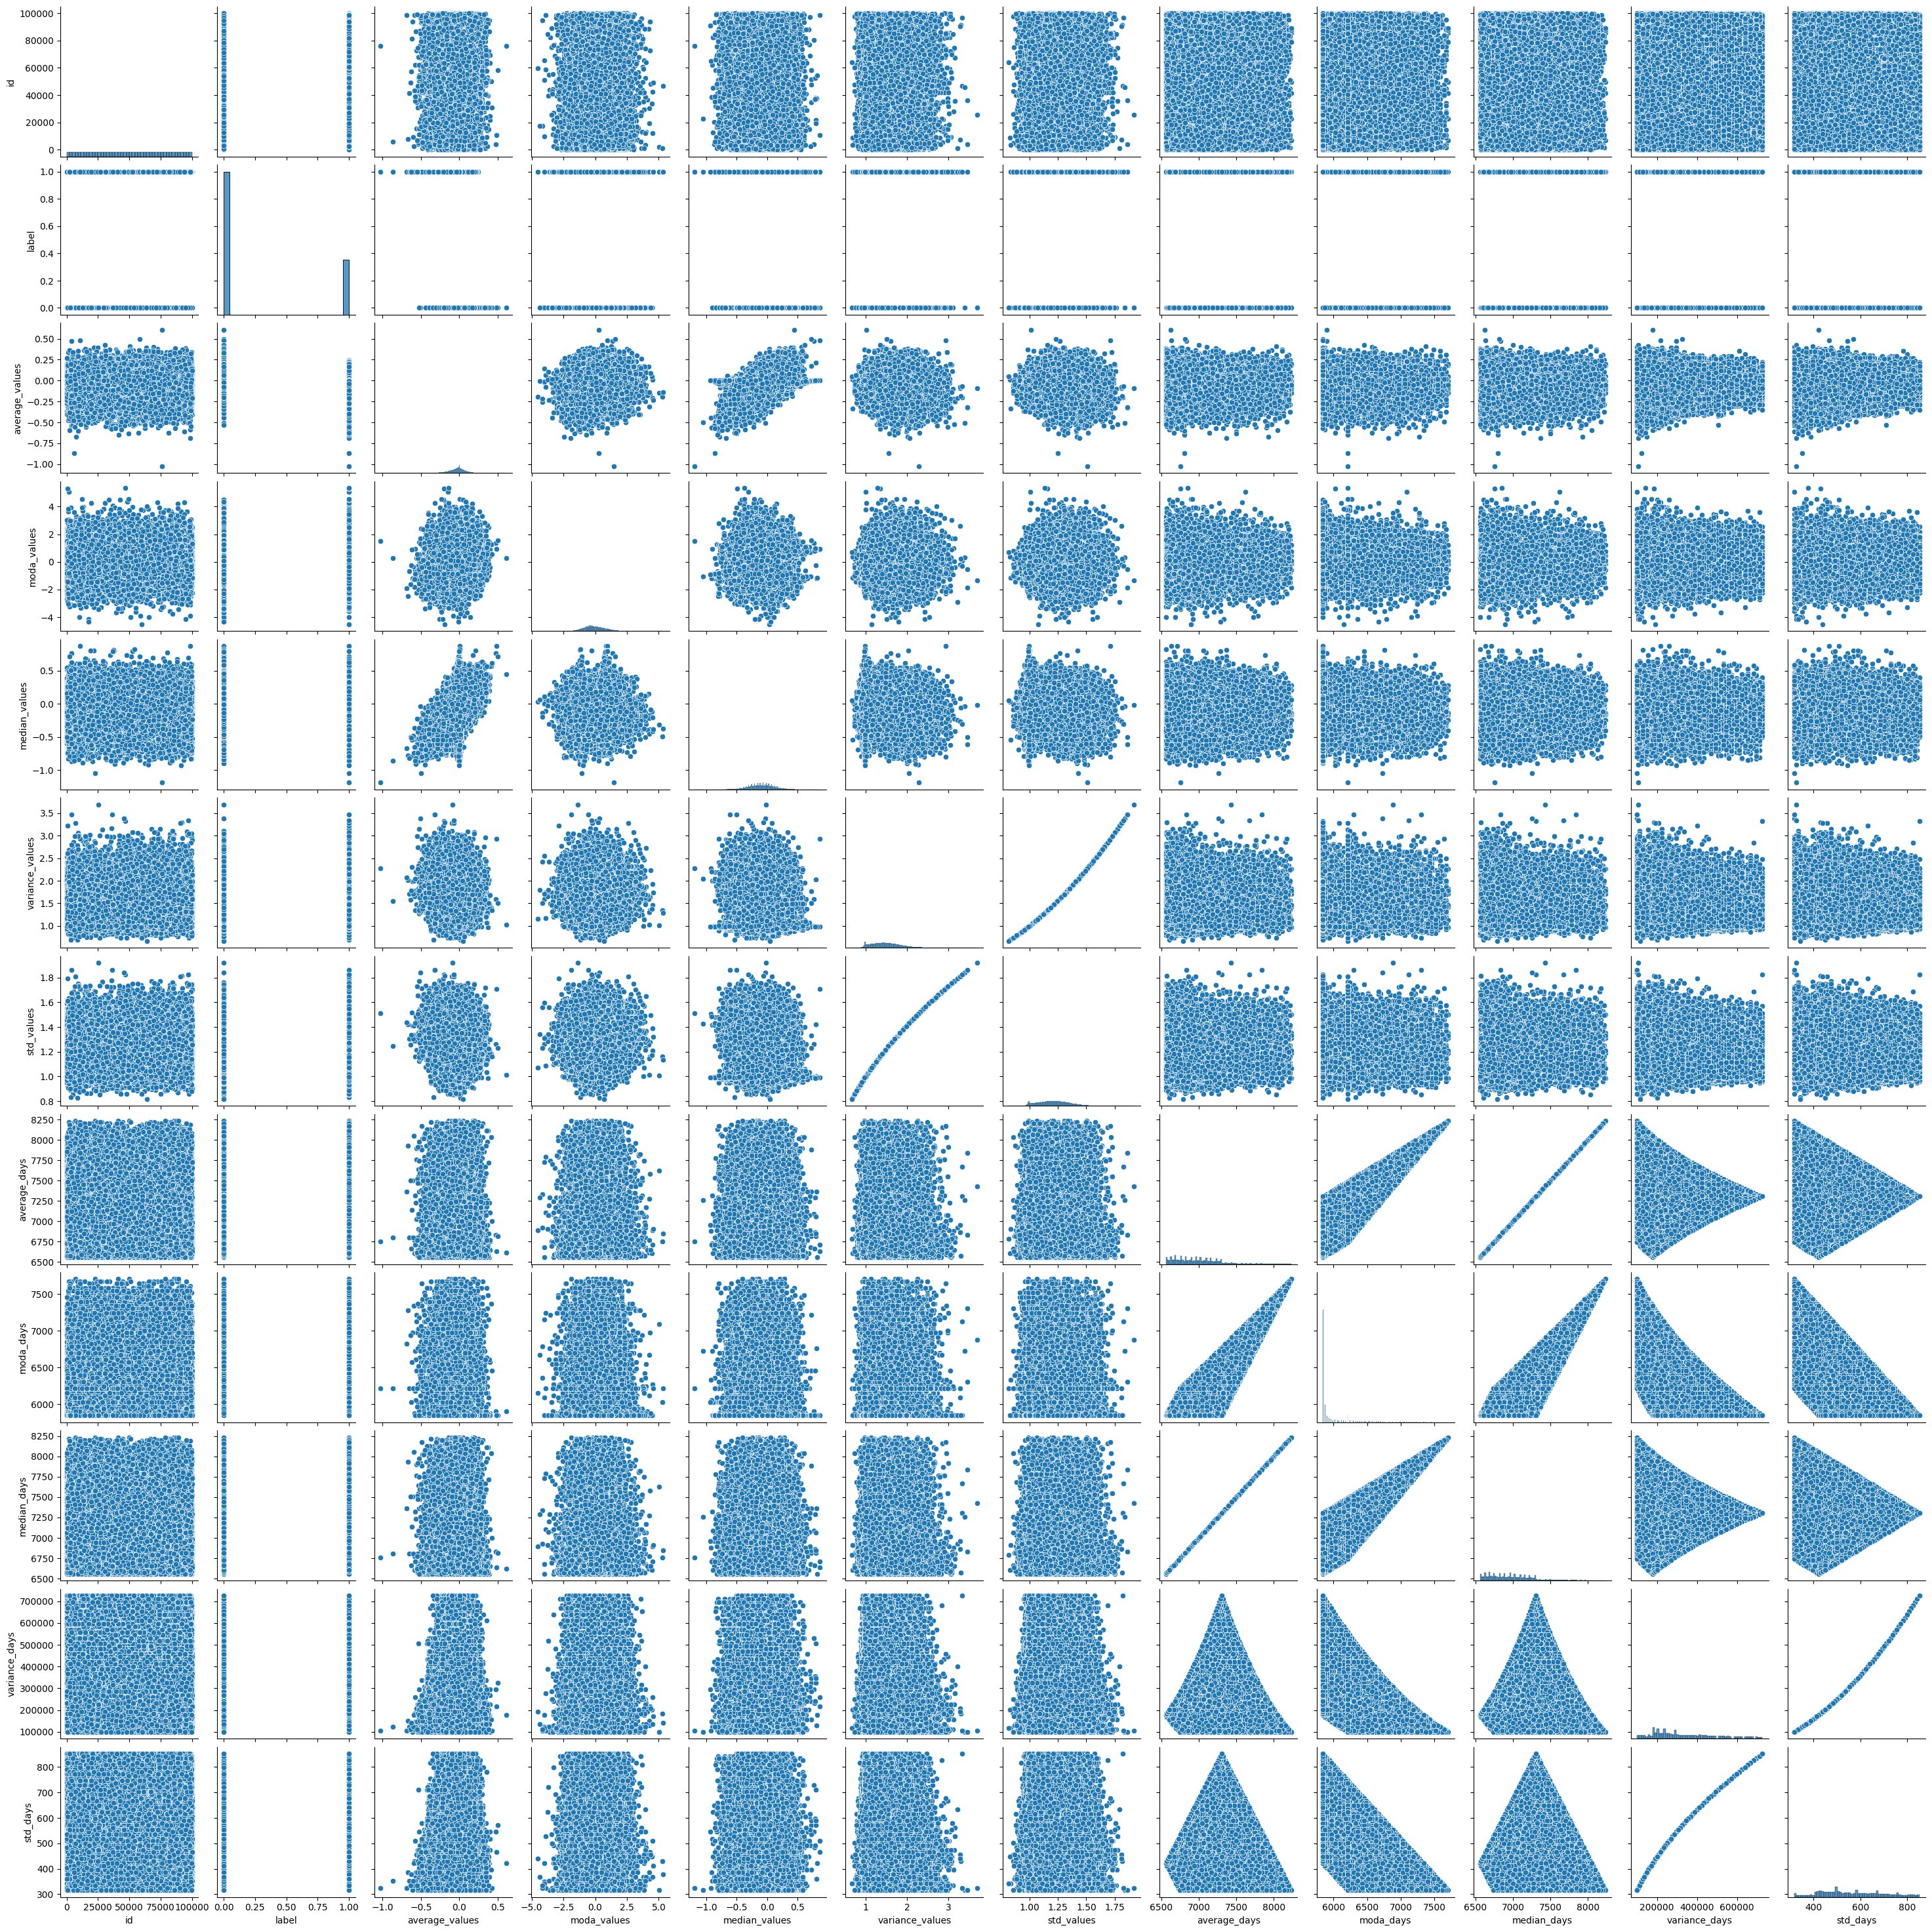

In [ ]:
sns.pairplot(changed_train[['id', 'label', 'average_values', 'moda_values',
                            'median_values', 'variance_values', 'std_values',
                            'average_days', 'moda_days', 'median_days', 'variance_days','std_days']])

In [ ]:
#there are outliers in the data.
#Interestingly, due to the uniform distribution of dates in the array, the graphs of the characteristics of the arrays have smooth edges
#The values, on the other hand, are distributed randomly, hence the graphs look less smooth

<Axes: title={'center': 'std_days'}>

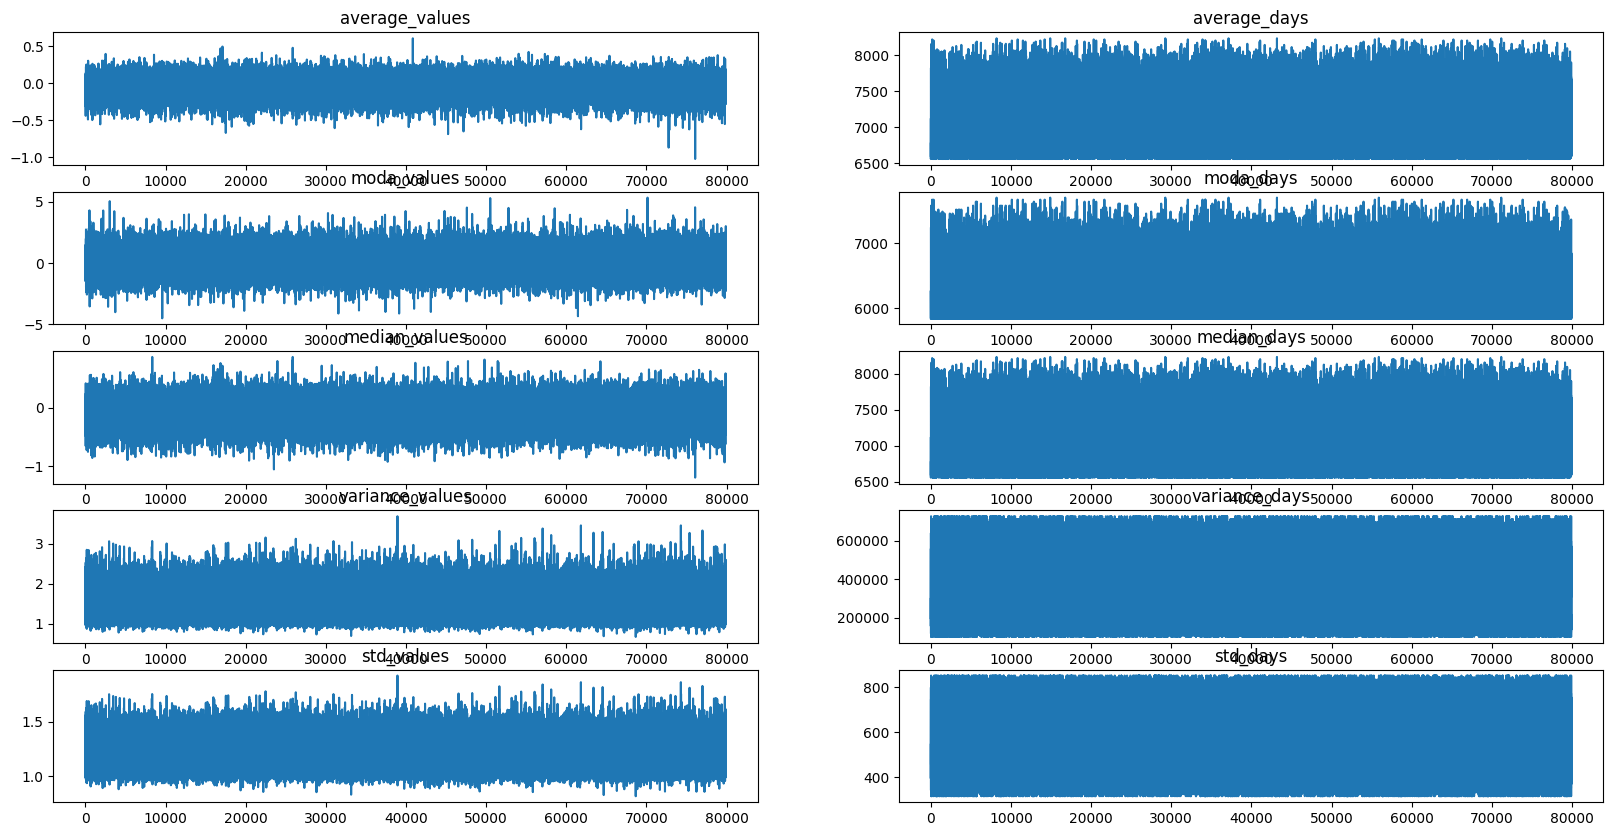

In [ ]:
figure, axes = plt.subplots(nrows = 5, ncols = 2,
                            figsize=(20, 10))
changed_train['average_values'].plot(kind='line',ax = axes[0,0], title = 'average_values')
changed_train['average_days'].plot(kind='line',ax=axes[0,1], title = 'average_days')
changed_train['moda_values'].plot(kind='line',ax = axes[1,0], title = 'moda_values')
changed_train['moda_days'].plot(kind='line',ax=axes[1,1], title = 'moda_days')
changed_train['median_values'].plot(kind='line',ax = axes[2,0], title = 'median_values')
changed_train['median_days'].plot(kind='line',ax=axes[2,1], title = 'median_days')
changed_train['variance_values'].plot(kind='line',ax = axes[3,0], title = 'variance_values')
changed_train['variance_days'].plot(kind='line',ax=axes[3,1], title = 'variance_days')
changed_train['std_values'].plot(kind='line',ax = axes[4,0], title = 'std_values')
changed_train['std_days'].plot(kind='line',ax=axes[4,1], title = 'std_days')

In [ ]:
#obvious outliners in values column

<Axes: title={'center': 'std_days'}, ylabel='Frequency'>

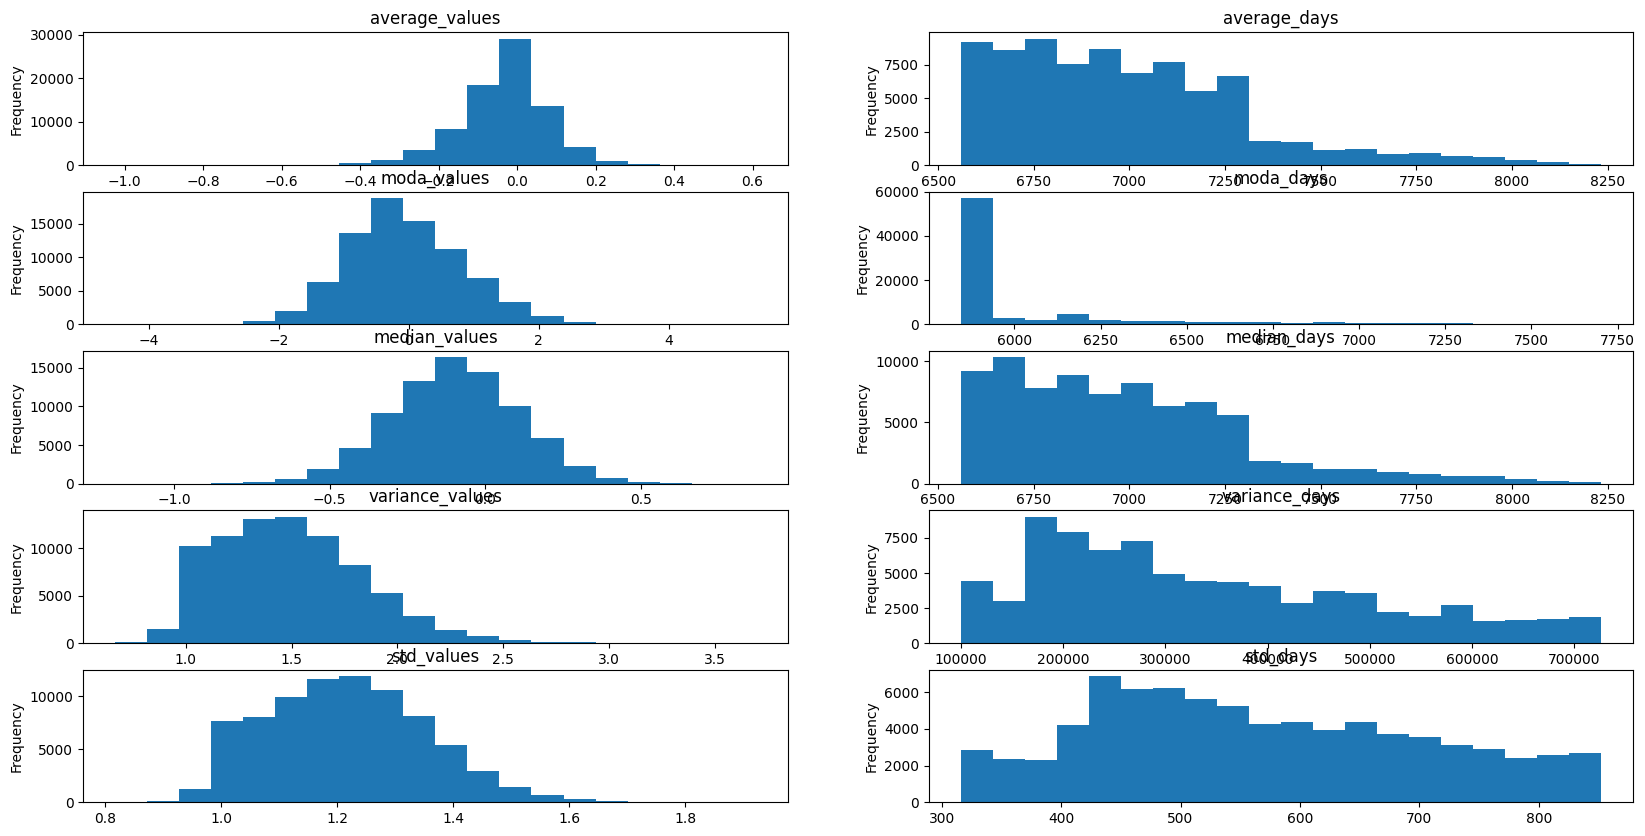

In [ ]:
figure, axes = plt.subplots(nrows = 5, ncols = 2,
                            figsize=(20, 10))
changed_train['average_values'].plot(kind='hist', bins=20,ax = axes[0,0], title = 'average_values')
changed_train['average_days'].plot(kind='hist', bins=20,ax=axes[0,1], title = 'average_days')
changed_train['moda_values'].plot(kind='hist', bins=20,ax = axes[1,0], title = 'moda_values')
changed_train['moda_days'].plot(kind='hist', bins=20,ax=axes[1,1], title = 'moda_days')
changed_train['median_values'].plot(kind='hist', bins=20,ax = axes[2,0], title = 'median_values')
changed_train['median_days'].plot(kind='hist', bins=20,ax=axes[2,1], title = 'median_days')
changed_train['variance_values'].plot(kind='hist', bins=20,ax = axes[3,0], title = 'variance_values')
changed_train['variance_days'].plot(kind='hist', bins=20,ax=axes[3,1], title = 'variance_days')
changed_train['std_values'].plot(kind='hist', bins=20,ax = axes[4,0], title = 'std_values')
changed_train['std_days'].plot(kind='hist', bins=20,ax=axes[4,1], title = 'std_days')



<Axes: >

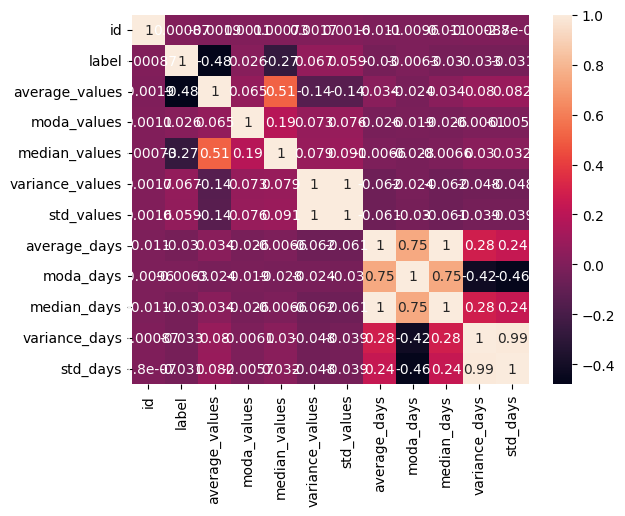

In [ ]:
corr = changed_train[['id', 'label', 'average_values', 'moda_values',
                      'median_values', 'variance_values', 'std_values',
                      'average_days', 'moda_days', 'median_days', 'variance_days','std_days']].corr()
sns.heatmap(corr,
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values,
            annot = True)

In [ ]:
#Big correlation between label and average_value - so it is quite important feature
#in average values there are outliers

In [ ]:
changed_train = changed_train.drop(columns = ['values','dates','days'])

#divide into 2 df by labels

In [ ]:
#divide into 2 df by labels to check if labels depends on the value directly
train_lbl1 = changed_train.where(orig_train['label']==1).dropna()
train_lbl2 = changed_train.where(orig_train['label']==0).dropna()

In [ ]:
train_lbl1.head()

id  label  average_values  moda_values  median_values  \
1   22769.0    1.0       -0.310777        -1.04      -0.274409   
8   87449.0    1.0       -0.062786        -0.22      -0.325000   
9   43415.0    1.0       -0.096252        -0.86      -0.350000   
18  94983.0    1.0       -0.163827         0.11       0.010000   
20  62582.0    1.0       -0.051988         0.25       0.100000   

    variance_values  std_values  average_days  moda_days  median_days  \
1          2.422185    1.556337   6635.044444     5965.0       6634.0   
8          1.011177    1.005573   6619.846154     5844.0       6620.0   
9          1.340649    1.157864   6969.958904     5875.0       6971.0   
18         1.205951    1.098158   7822.230769     7244.0       7822.0   
20         1.971103    1.403960   7106.878049     5875.0       7106.0   

    variance_days    std_days  
1   156098.442469  395.092954  
8   208529.860947  456.650699  
9   411388.614749  641.395833  
18  117299.305720  342.489862  
20  518979.155860  720.402079

In [ ]:
train_lbl2.head()

id  label  average_values  moda_values  median_values  \
0  19114.0    0.0        0.023710         0.00         -0.110   
2  76935.0    0.0       -0.046042        -0.51         -0.145   
3  66297.0    0.0       -0.130000        -0.95         -0.345   
4   2191.0    0.0       -0.270536        -0.54         -0.475   
5  59504.0    0.0        0.118689         0.08          0.060   

   variance_values  std_values  average_days  moda_days  median_days  \
0         1.788298    1.337272   6772.112903     5844.0       6771.5   
2         1.134274    1.065023   6985.083333     6269.0       6985.0   
3         1.341429    1.158201   6558.958333     5844.0       6559.5   
4         1.614244    1.270529   6680.714286     5844.0       6680.0   
5         1.343385    1.159045   6817.737705     5904.0       6818.0   

   variance_days    std_days  
0  296706.809834  544.708004  
2  177964.576389  421.858479  
3  177617.081597  421.446416  
4  241882.561224  491.815576  
5  287216.160709  535.925518

In [ ]:
print(train_lbl1['id'].count(),train_lbl2['id'].count())

22166 57746


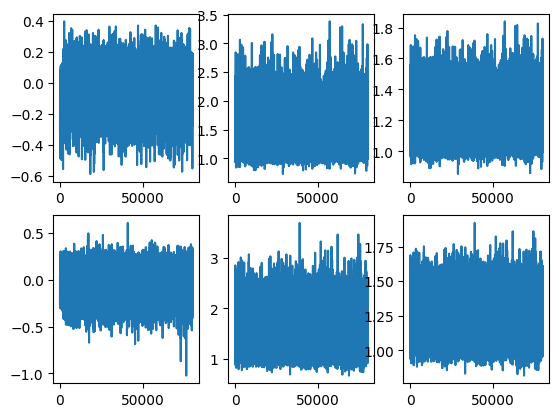

In [ ]:
#check on graphs

fig, ax = plt.subplots(nrows=2, ncols=3)
ax[0,0].plot(train_lbl1['average_values'])
ax[1,0].plot(train_lbl2['average_values'])
ax[0,1].plot(train_lbl1['variance_values'])
ax[1,1].plot(train_lbl2['variance_values'])
ax[0,2].plot(train_lbl1['std_values'])
ax[1,2].plot(train_lbl2['std_values'])

#classes have almost the same distribution in values arrays

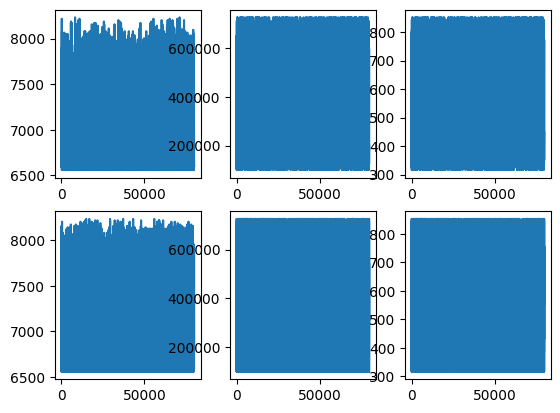

In [ ]:
#check same aboun dates on graphs

fig, ax = plt.subplots(nrows=2, ncols=3)
ax[0,0].plot(train_lbl1['average_days'])
ax[1,0].plot(train_lbl2['average_days'])
ax[0,1].plot(train_lbl1['variance_days'])
ax[1,1].plot(train_lbl2['variance_days'])
ax[0,2].plot(train_lbl1['std_days'])
ax[1,2].plot(train_lbl2['std_days'])

#classes have almost the same distribution in dates arrays too

In [ ]:
#there is no big difference about labels

#Anomalies

<Axes: ylabel='std_days'>

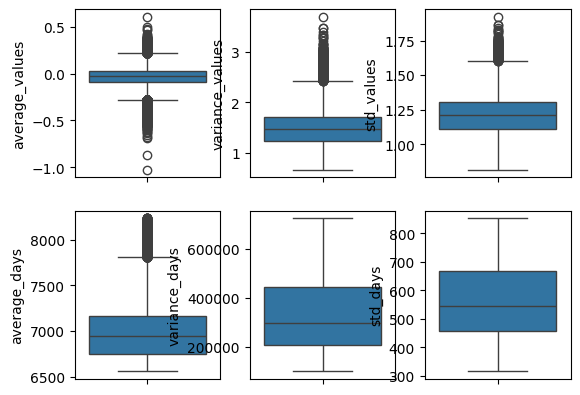

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=3)
sns.boxplot(changed_train['average_values'], ax = ax[0,0])
sns.boxplot(changed_train['average_days'], ax = ax[1,0])
sns.boxplot(changed_train['variance_values'], ax = ax[0,1])
sns.boxplot(changed_train['variance_days'], ax = ax[1,1])
sns.boxplot(changed_train['std_values'], ax = ax[0,2])
sns.boxplot(changed_train['std_days'], ax = ax[1,2])

In [ ]:
#all dots are outliners, there are a lot of them in values arrays, but just a bit in dates

In [ ]:
changed_train.shape

(79912, 12)

In [ ]:
#drop by quantiles:
q1 = changed_train['average_values'].quantile(0.99)
print(q1)
len(changed_train[changed_train['average_values']>=q])

0.2178359320859321


0

In [ ]:
q2 = changed_train['variance_values'].quantile(0.99)
print(q2)
len(changed_train[changed_train['variance_values']>=q])

2.416552542289632


0

In [ ]:
q3 = changed_train['std_values'].quantile(0.99)
print(q3)
len(changed_train[changed_train['std_values']>=q])

1.5545264682914093


0

In [ ]:
q4 = changed_train['average_days'].quantile(0.99)
print(q4)
len(changed_train[changed_train['average_days']>=q])

7974.292682926829


79912

In [ ]:
q5 = changed_train['variance_days'].quantile(0.99)
print(q5)
len(changed_train[changed_train['variance_days']>=q])

711247.3315972224


79912

In [ ]:
q6 = changed_train['std_days'].quantile(0.99)
print(q6)
len(changed_train[changed_train['std_days']>=q])

843.3548076564349


1065

In [ ]:
changed_train = changed_train[changed_train['average_values']<q1]
changed_train = changed_train[changed_train['variance_values']<q2]
changed_train = changed_train[changed_train['std_values']<q3]
changed_train = changed_train[changed_train['average_days']<q4]
changed_train = changed_train[changed_train['variance_days']<q5]
changed_train = changed_train[changed_train['std_days']<q6]
rows, cols = changed_train.shape
print('New number of rows: ', rows)

New number of rows:  76502


#Feature important with chi-2

In [ ]:
#to check feature importance there shouldnt be negative values:
changed_train['non-negative_average'] = [int(x+10) for x in changed_train['average_values']]
changed_train['non-negative_median'] = [int(x+10) for x in changed_train['median_values']]
changed_train['non-negative_moda'] = [int(x+10) for x in changed_train['moda_values']]


In [ ]:
changed_train.columns

Index(['id', 'label', 'average_values', 'moda_values', 'median_values',
       'variance_values', 'std_values', 'average_days', 'moda_days',
       'median_days', 'variance_days', 'std_days', 'non-negative_average',
       'non-negative_median', 'non-negative_moda'],
      dtype='object')

In [ ]:
X = changed_train[['id', 'variance_values', 'std_values', 'average_days', 'moda_days',
       'median_days', 'variance_days', 'std_days', 'non-negative_average',
       'non-negative_median', 'non-negative_moda']]
y = changed_train['label']

Best_features = SelectKBest(score_func = chi2, k = 'all')
fit = Best_features.fit(X,y)

dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)

featureScores = pd.concat([dfcolumns, dfscores], axis = 1)
featureScores.columns = ['Specs', 'scores']
featureScores

Specs        scores
0                     id  1.865765e+03
1        variance_values  1.700072e+01
2             std_values  2.712287e+00
3           average_days  8.949738e+02
4              moda_days  4.976493e+01
5            median_days  8.948292e+02
6          variance_days  5.627079e+06
7               std_days  2.243358e+03
8   non-negative_average  2.578625e+02
9    non-negative_median  5.670259e+01
10     non-negative_moda  5.220757e+00

In [ ]:
#interesting, that by chi-2 number of days are more important, espesially variance
#and id occasionally is quite important)

In [ ]:
changed_train = changed_train.drop(columns = ['id', 'non-negative_average', 'non-negative_median', 'non-negative_moda'])

#Oversampling

In [ ]:
ros = RandomOverSampler()
X = changed_train.drop(columns=['label'])
y = changed_train['label']

X_res, y_res = ros.fit_resample(X, y)

In [ ]:
X_res.shape

(110492, 10)

In [ ]:
print(X_res.columns)
print(changed_train.columns)

Index(['average_values', 'moda_values', 'median_values', 'variance_values',
       'std_values', 'average_days', 'moda_days', 'median_days',
       'variance_days', 'std_days'],
      dtype='object')
Index(['label', 'average_values', 'moda_values', 'median_values',
       'variance_values', 'std_values', 'average_days', 'moda_days',
       'median_days', 'variance_days', 'std_days'],
      dtype='object')


#Normalization

In [ ]:
norm = MinMaxScaler()

X = X_res
y = y_res

X_res_norm = norm.fit_transform(X)
X_end = pd.DataFrame(X_res_norm, columns = [X_res.columns])

In [ ]:
X_end[0:3]

average_values moda_values median_values variance_values std_values  \
0       0.843733    0.458418      0.524288        0.640999   0.705614   
1       0.787581    0.406694      0.507298        0.267059   0.336510   
2       0.719991    0.362069      0.410214        0.385501   0.462836   

  average_days moda_days median_days variance_days  std_days  
0     0.152231  0.000000    0.151429      0.329917  0.441036  
1     0.304330  0.268647    0.303929      0.130920  0.204155  
2     0.000000  0.000000    0.000000      0.130338  0.203360

In [ ]:
res_train = X_end
res_train['label'] = y_res

In [ ]:
res_train.shape

(110492, 11)

In [ ]:
res_train.head()

average_values moda_values median_values variance_values std_values  \
0       0.843733    0.458418      0.524288        0.640999   0.705614   
1       0.787581    0.406694      0.507298        0.267059   0.336510   
2       0.719991    0.362069      0.410214        0.385501   0.462836   
3       0.606854    0.403651      0.347109        0.541484   0.615126   
4       0.920195    0.466531      0.606809        0.386619   0.463981   

  average_days moda_days median_days variance_days  std_days label  
0     0.152231  0.000000    0.151429      0.329917  0.441036   0.0  
1     0.304330  0.268647    0.303929      0.130920  0.204155   0.0  
2     0.000000  0.000000    0.000000      0.130338  0.203360   0.0  
3     0.086956  0.000000    0.086071      0.238039  0.339047   0.0  
4     0.184815  0.037927    0.184643      0.314012  0.424101   0.0

In [ ]:
res_train.to_parquet('processed_train.parquet')